## 네이버 영화리뷰 텍스트 감성분석하기 🎬🙄💭

💬 영화리뷰 텍스트를 임베딩 레이어를 이용하여 감성 분석하는 프로젝트입니다.

___

### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import numpy as np
import os


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')


print(len(train_data), len(test_data))
train_data.head()

150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


___

### 2. 데이터로더 구성

네이버 영화리뷰 데이터를 살펴보자.

먼저, 중복되는 값이 있는지 본다.

In [2]:
train_data['document'].nunique()

146182

3818개의 중복 데이터가 존재한다. -> **삭제해주어야 함!**

결측치가 있는지 확인해 보자.

In [3]:
for c in train_data.columns:
    print('{} : {}'.format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

id : 0
document : 5
label : 0


`document` 열에 5개의 `null`데이터가 있다. -> **삭제해주어야 함!**

In [4]:
train_data['label']

0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 150000, dtype: int64

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 데이터 중복 제거
    train_data.drop_duplicates(['document'])
    
    # 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')
    
    # 토큰화(+ stopwords 제거)
    X_train = []
    for x in train_data['document']:
        tokens = tokenizer.morphs(x)
        if tokens not in stopwords:
            X_train.append(tokens)
    
    X_test = []
    for x in test_data['document']:
        tokens = tokenizer.morphs(x)
        if tokens not in stopwords:
            X_test.append(tokens)
            
    # `word_to_index` 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
            
    y_train = train_data['label']
    
    y_test = test_data['label']          
    
    
    return X_train, y_train, X_test, y_test, word_to_index
    
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
print(X_train[0])
print(X_test[0])

[43, 88, 938, 4, 4, 50, 246, 30, 44, 769]
[748, 145]


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

___

### 3. 모델 구성을 위한 데이터 분석 및 가공

데이터셋의 문장 길이를 파악해보자.

분포를 보고 적절한 최대 문장 길이를 설정한다.

In [9]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[43, 88, 938, 4, 4, 50, 246, 30, 44, 769]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


최대 문장길이를 평균 + 2\*표준편자로 설정한다

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  18.3542491699668
문장길이 최대 :  116
문장길이 표준편차 :  15.347552229578971
pad_sequences maxlen :  49
전체 문장의 0.9361724468978759%가 maxlen 설정값 이내에 포함됩니다. 


`keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가

In [11]:
import tensorflow as tf
from tensorflow import keras

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(149995, 49)
(49997, 49)


___

### 4. 모델 구성, 학습, 성능 평가

`validation set`을 `train data`의 20%로 정한다.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=34)

print(len(X_train))
print(len(X_val))

119996
29999


모델을 총 3개지로 구현해 볼 것임.

___

### (1) RNN 모델

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


`InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory`라는 오류가 떠서 구글링 한 결과 GPU 메모리가 부족해서 그렇다고 한다. 아래 코드를 넣어보라고 해서 가져왔다. 

그래도 안돼서 다른 모델들을 넣어봤는데도 안됐다.

열심히 구글링해서 이번엔 GPU 메모리를 초기화해줬다. 그래도 안됐다. 

**알고보니 Jupyter Notebook을 두 개 켜놔서 그런거였다...! 하나를 shutdown하니 해결됨 😇**

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
if gpus: # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한 
    try: tf.config.experimental.set_virtual_device_configuration( gpus[0],
                                                                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e: # 프로그램 시작시에 가상 장치가 설정되어야만 합니다 
        print(e)

Virtual devices cannot be modified after being initialized


다시 RNN 모델을 가져온다.

___

### vocab=10000, wvd=32, LSTM layers=16, epoch=7 👉정확도=0.8481

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
235/235 [==============================] - 5s 8ms/step - loss: 0.4736 - accuracy: 0.7849 - val_loss: 0.3606 - val_accuracy: 0.8458
Epoch 2/7
235/235 [==============================] - 1s 6ms/step - loss: 0.3339 - accuracy: 0.8600 - val_loss: 0.3441 - val_accuracy: 0.8524
Epoch 3/7
235/235 [==============================] - 1s 6ms/step - loss: 0.3104 - accuracy: 0.8705 - val_loss: 0.3425 - val_accuracy: 0.8544
Epoch 4/7
235/235 [==============================] - 1s 6ms/step - loss: 0.2973 - accuracy: 0.8765 - val_loss: 0.3422 - val_accuracy: 0.8525
Epoch 5/7
235/235 [==============================] - 1s 6ms/step - loss: 0.2840 - accuracy: 0.8824 - val_loss: 0.3456 - val_accuracy: 0.8513
Epoch 6/7
235/235 [==============================] - 1s 6ms/step - loss: 0.2715 - accuracy: 0.8878 - val_loss: 0.3429 - val_accuracy: 0.8528
Epoch 7/7
235/235 [==============================] - 1s 6ms/step - loss: 0.2589 - accuracy: 0.8944 - val_loss: 0.3525 - val_accuracy: 0.8514


In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 3s - loss: 0.3588 - accuracy: 0.8483
[0.35875317454338074, 0.8483108878135681]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


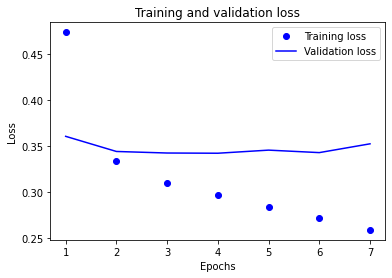

In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

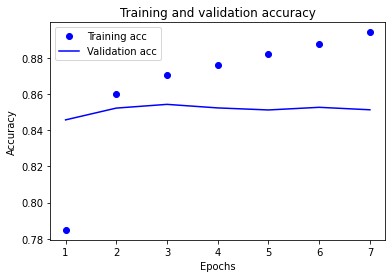

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

첫번째로 설계한 모델의 경우 에포크의 값이 작을수록 `val_acc`가 높게 나왔다. 큰 차이는 아니어서 에포크값을 조정하진 않았고, 다음 모델을 학습시켜봤다.

___

### (2) 1-D CNN 모델

### vocab=10000, wvd=32, Conv1Dlayers=16, epoch=10 👉정확도=0.7794

In [20]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 3s 6ms/step - loss: 0.5481 - accuracy: 0.6967 - val_loss: 0.4326 - val_accuracy: 0.7887
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3978 - accuracy: 0.8120 - val_loss: 0.4160 - val_accuracy: 0.8005
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.8330 - val_loss: 0.4209 - val_accuracy: 0.8000
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3225 - accuracy: 0.8520 - val_loss: 0.4324 - val_accuracy: 0.7967
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2818 - accuracy: 0.8741 - val_loss: 0.4555 - val_accuracy: 0.7952
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2387 - accuracy: 0.8949 - val_loss: 0.4992 - val_accuracy: 0.7926
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2022 - accuracy: 0.9116 - val_loss: 0.5446 - val_accuracy: 0.7894
Epoch 

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 3s - loss: 0.7393 - accuracy: 0.7752
[0.7393388748168945, 0.7752465009689331]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


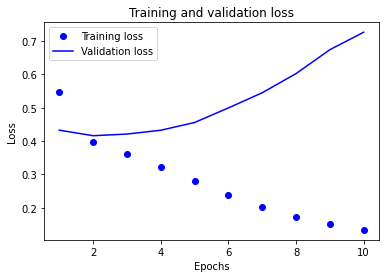

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

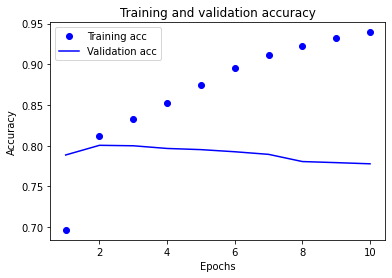

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이번에도 에포크의 값이 작을수록 `val_acc`가 높게 나왔다. 하이퍼 파라미터를 조정해서 다시 1-D CNN 모델을 학습시켰다.

___

### vocab=10000, wvd=64, Conv1Dlayers=32, epoch=10 👉정확도=0.7781

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =64  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          14368     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 3s 7ms/step - loss: 0.5211 - accuracy: 0.7247 - val_loss: 0.4238 - val_accuracy: 0.7949
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.3874 - accuracy: 0.8170 - val_loss: 0.4101 - val_accuracy: 0.8017
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.3402 - accuracy: 0.8434 - val_loss: 0.4198 - val_accuracy: 0.7973
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2847 - accuracy: 0.8718 - val_loss: 0.4423 - val_accuracy: 0.7988
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.2254 - accuracy: 0.9009 - val_loss: 0.4922 - val_accuracy: 0.7936
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1752 - accuracy: 0.9216 - val_loss: 0.5733 - val_accuracy: 0.7911
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1393 - accuracy: 0.9364 - val_loss: 0.6523 - val_accuracy: 0.7867
Epoch 

In [27]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 3s - loss: 0.9155 - accuracy: 0.7815
[0.9154561758041382, 0.7815068960189819]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


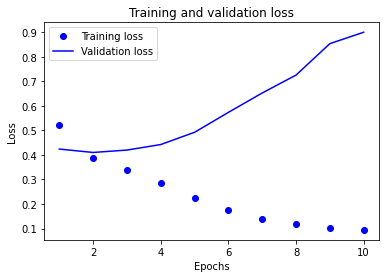

In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

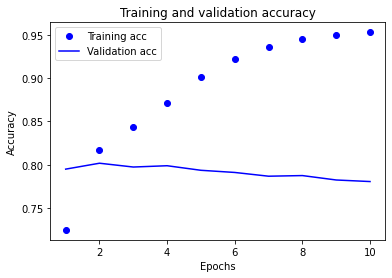

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

에포크값은 여전히 작을수록 좋다. 모델이 복잡해진다고해서 성능이 좋아지진 않았다. 그럼 반대로 좀 더 간단하게 만들어 보자.

___

### vocab=10000, wvd=16, Conv1Dlayers=8, epoch=10 👉정확도=0.7765

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(8, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(8, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 8)           904       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 8)           456       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.5683 - accuracy: 0.7040 - val_loss: 0.4449 - val_accuracy: 0.7825
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.4090 - accuracy: 0.8063 - val_loss: 0.4237 - val_accuracy: 0.7978
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3759 - accuracy: 0.8244 - val_loss: 0.4220 - val_accuracy: 0.7986
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3506 - accuracy: 0.8379 - val_loss: 0.4278 - val_accuracy: 0.7936
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8515 - val_loss: 0.4417 - val_accuracy: 0.7932
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2988 - accuracy: 0.8655 - val_loss: 0.4599 - val_accuracy: 0.7916
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2719 - accuracy: 0.8789 - val_loss: 0.4862 - val_accuracy: 0.7873
Epoch 

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 3s - loss: 0.5963 - accuracy: 0.7798
[0.5962512493133545, 0.7798267602920532]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


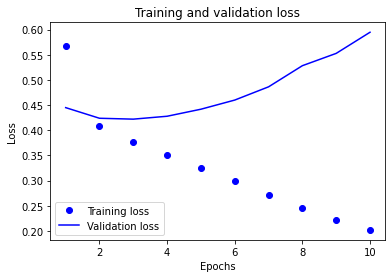

In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

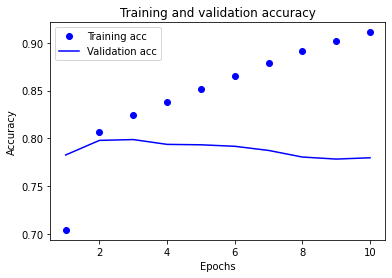

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1-D CNN모델은 RNN에 비해서 전반적으로 성능이 잘 나오지 않는 것 같다.

___

### (3) `GlobalMaxPooling1D()`를 이용한 CNN

### vocab=10000, wvd=32, epoch=10 👉정확도=0.8386

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.5463 - accuracy: 0.7887 - val_loss: 0.3848 - val_accuracy: 0.8340
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.3457 - accuracy: 0.8527 - val_loss: 0.3467 - val_accuracy: 0.8477
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.3018 - accuracy: 0.8742 - val_loss: 0.3420 - val_accuracy: 0.8509
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.2745 - accuracy: 0.8879 - val_loss: 0.3454 - val_accuracy: 0.8518
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.2525 - accuracy: 0.8985 - val_loss: 0.3516 - val_accuracy: 0.8516
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.2333 - accuracy: 0.9073 - val_loss: 0.3626 - val_accuracy: 0.8503
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 0.2155 - accuracy: 0.9169 - val_loss: 0.3765 - val_accuracy: 0.8494
Epoch 

In [37]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 2s - loss: 0.4346 - accuracy: 0.8391
[0.434636652469635, 0.8391103744506836]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


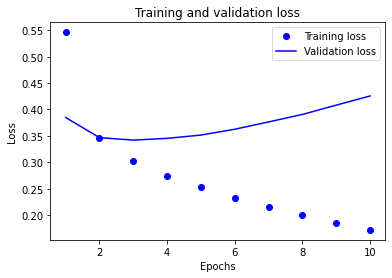

In [38]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

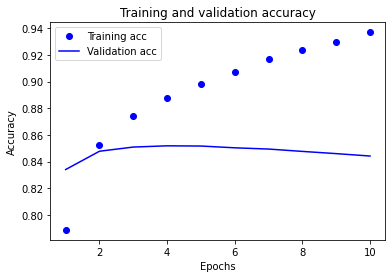

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3번째 모델은 1-D CNN모델에 비해서는 성능이 괜찮은 것 같다. 하이퍼 파라미터를 조정해보자.

___

### vocab=10000, wvd=16, epoch=5 👉정확도=0.8416

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim =16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 1s 4ms/step - loss: 0.5940 - accuracy: 0.7345 - val_loss: 0.4355 - val_accuracy: 0.8206
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.3773 - accuracy: 0.8404 - val_loss: 0.3612 - val_accuracy: 0.8411
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.3240 - accuracy: 0.8636 - val_loss: 0.3493 - val_accuracy: 0.8473
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2958 - accuracy: 0.8777 - val_loss: 0.3472 - val_accuracy: 0.8492
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2748 - accuracy: 0.8878 - val_loss: 0.3506 - val_accuracy: 0.8499


In [42]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 2s - loss: 0.3591 - accuracy: 0.8466
[0.3591291010379791, 0.8465508222579956]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


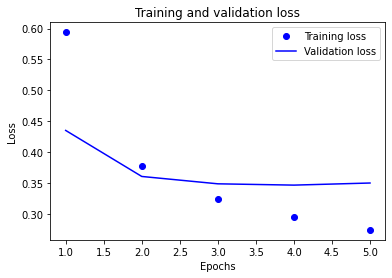

In [43]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

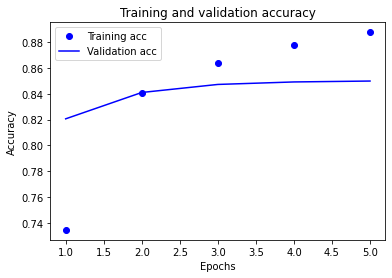

In [44]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3번째 모델은 1-D CNN모델에 비해서는 성능이 괜찮은 것 같다. 하이퍼 파라미터를 조정해보자.

___

### 5. 한국어 `Word2Vec` 임베딩 활용하여 성능 개선

세 가지 모델들의 하이퍼파라미터 튜닝만으로는 성능개선에 한계가 있는 것 같다. `Word2Vec` 임베딩을 활용하여 성능 개선을 노려보자.

`gensim` 버전이 3.x.x 이하여야 오류가 나지 않는다고 하니 버전을 먼저 확인해보자.

In [45]:
from importlib_metadata import version
print(version('gensim'))

3.8.3


`4.1.2` 버전이라고 한다.

Cloud Shell에서

```
pip uninstal gensim
pip install gensim==3.8.3.
```
해준다.

In [46]:
from importlib_metadata import version
print(version('gensim'))

3.8.3


`3.8.3`으로 잘 다운그레이드되었다!

___

이제 다운받은 한국어 `Word2Vec` 임베딩 모델을 가져와 준다.

In [47]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [48]:
word2vec.wv.similar_by_word("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

"사랑"과 가장 유사한 단어가 "슬픔"이라니! 🥺

In [49]:
word2vec.wv.similar_by_word("인공지능")

[('컴퓨팅', 0.6520194411277771),
 ('가상현실', 0.6393702030181885),
 ('심리학', 0.63037109375),
 ('모델링', 0.625065267086029),
 ('신경망', 0.6200424432754517),
 ('로봇', 0.6109743118286133),
 ('시뮬레이션', 0.6101070642471313),
 ('지능', 0.6092983484268188),
 ('기술', 0.6087720990180969),
 ('기술인', 0.5957075953483582)]

In [50]:
word2vec.wv.similar_by_word("영화")

[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

`Word2Vec`은 한국어 버전도 굉장히 성능이 좋다!

___

### 이제 `Word2Vec`을 이용하여 모델을 새로 만들고 학습시킨다. 가장 성능이 좋았던 RNN모델로 만들어보자.

In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_5924/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5924/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [64]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 49, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_22 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 2,170,529
Trainable params: 2,170,529
Non-trainable params: 0
_________________________________________________________________


In [65]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 5s 18ms/step - loss: 0.4512 - accuracy: 0.7821 - val_loss: 0.3653 - val_accuracy: 0.8376
Epoch 2/10
235/235 [==============================] - 4s 16ms/step - loss: 0.3207 - accuracy: 0.8621 - val_loss: 0.3278 - val_accuracy: 0.8547
Epoch 3/10
235/235 [==============================] - 4s 16ms/step - loss: 0.2794 - accuracy: 0.8824 - val_loss: 0.3168 - val_accuracy: 0.8632
Epoch 4/10
235/235 [==============================] - 4s 16ms/step - loss: 0.2498 - accuracy: 0.8967 - val_loss: 0.3204 - val_accuracy: 0.8672
Epoch 5/10
235/235 [==============================] - 4s 16ms/step - loss: 0.2245 - accuracy: 0.9091 - val_loss: 0.3179 - val_accuracy: 0.8683
Epoch 6/10
235/235 [==============================] - 4s 16ms/step - loss: 0.1996 - accuracy: 0.9201 - val_loss: 0.3247 - val_accuracy: 0.8672
Epoch 7/10
235/235 [==============================] - 4s 16ms/step - loss: 0.1743 - accuracy: 0.9317 - val_loss: 0.3553 - val_accuracy: 0.8649

In [66]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 4s - loss: 0.4856 - accuracy: 0.8571
[0.4856402277946472, 0.8571314215660095]


## 정확도 85%를 넘겼다!!!! 🙊

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


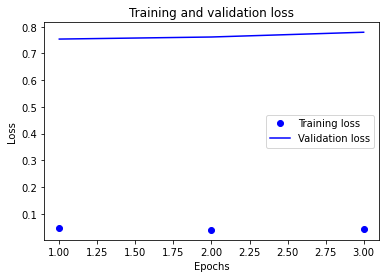

In [74]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

과적합된 것 같으니 에포크를 조금 줄여서 다시 평가해보자.

___

### epoch=3 일 때

In [72]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
235/235 [==============================] - 5s 18ms/step - loss: 0.0471 - accuracy: 0.9832 - val_loss: 0.7537 - val_accuracy: 0.8571
Epoch 2/3
235/235 [==============================] - 4s 16ms/step - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.7614 - val_accuracy: 0.8532
Epoch 3/3
235/235 [==============================] - 4s 16ms/step - loss: 0.0424 - accuracy: 0.9842 - val_loss: 0.7792 - val_accuracy: 0.8561


In [73]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1563/1563 - 4s - loss: 0.8040 - accuracy: 0.8545
[0.8039898872375488, 0.8544712662696838]


### 별 차이 없다. 이정도가 한계인듯!

## `최종 정확도=0.8571`

___

## 🤔회고

1) 컴퓨터가 이렇게 감정을 잘 읽어내다니? **인간인 나보다 맥락파악 잘하는 것 같다.**

2) `load_data` 함수를 구현하는 것이 제일 어려웠다. 구글링해서 어찌 저찌 해결하긴 했지만 모든 코드를 다 이해하지는 못했다. 

3) 패키지의 버전 문제, GPU의 메모리 문제 등으로 에러가 나서 시간이 오래 소요됐는데, 만약 내가 로컬에서 개인적인 프로젝트를 하려고 하면 이런 에러를 더 자주 맞닥뜨릴 것 같다. 다행히도 대부분의 에러는 구글링으로 해결이 가능했다. 부딪혀서 해결하는 훈련이 중요한 것 같다.

